# Tensor, boxes and operations
## By: Javier Orduz

There is one thing that Python’s numpy module is good at though: computing with multi-dimensional arrays, a.k.a. **tensors.** We can interpret tensors as cooking steps with the dimensions of their axes as ingredients, i.e. **tensors are boxes.**

```python
Dim(dimension)
``` 
is a subclass of ```Ty```. Integers are $\gt 1.$ Multiplication as tensor and the unit ```Dim(1)```.
```Tensor ``` is a subclass of ```Box``` defined by a pair od dimensions ```dom```, ```cod``` and ```array```.

In [2]:
from discopy import Dim, Tensor

matrix = Tensor(Dim(2), Dim(2), [0, 1, 1, 0])

matrix.array

array([[0, 1],
       [1, 0]])

Composition is given by matrix multiplication, with 
```python 
Tensor.id
``` 
as identity, e.g.

In [3]:
assert matrix >> Tensor.id(Dim(2)) == matrix == Tensor.id(Dim(2)) >> matrix

vector = Tensor(Dim(1), Dim(2), [0, 1])

vector >> matrix

Tensor(dom=Dim(1), cod=Dim(2), array=[1, 0])

Tensor is given by the Kronecker product, with 
``` python
Tensor.id(Dim(1))
```
as unit, e.g.

In [4]:
assert Tensor.id(Dim(1)) @ matrix == matrix == matrix @ Tensor.id(Dim(1))

Tensor.id(Dim(1))

Tensor(dom=Dim(1), cod=Dim(1), array=[1.])

the matrix products

In [6]:
vector @ vector

Tensor(dom=Dim(1), cod=Dim(2, 2), array=[0, 0, 0, 1])

and

In [7]:
vector @ matrix

Tensor(dom=Dim(2), cod=Dim(2, 2), array=[0, 0, 0, 1, 0, 0, 1, 0])

This is the same product with ```numpy```
```python
import numpy as np

assert np.all(
    (matrix >> matrix).array == matrix.array.dot(matrix.array))
assert np.all(
    (matrix @ matrix).array == np.moveaxis(np.tensordot(
    matrix.array, matrix.array, 0), range(4), [0, 2, 1, 3]))
```

We can compute the conjugate transpose of a tensor using [::-1] (dagger). Namely, 
$O = O^\dagger $ 

In [9]:
matrix = Tensor(Dim(2), Dim(2), [0, -1j, 1j, 0])

matrix >> matrix[::-1]

Tensor(dom=Dim(2), cod=Dim(2), array=[1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])

Thus, we can compute the inner product of two vectors as a scalar tensor. E.g. $\vec{v}\cdot \vec{v}^{\dagger}$

In [10]:
vector1 = Tensor(Dim(1), Dim(2), [-1j, 1j])

vector >> vector1[::-1]

Tensor(dom=Dim(1), cod=Dim(1), array=[0.-1.j])

We can add tensors elementwise, with the unit given by
```python
Tensor.zeros
```

In [11]:
vector + vector

Tensor(dom=Dim(1), cod=Dim(2), array=[0, 2])

In [12]:
zero = Tensor.zeros(Dim(1), Dim(2))
assert vector + zero == vector == zero + vector

We can reorder the axes of the ```domain``` or ```codomain``` of a tensor by composing it with ```Tensor.swap```.


In [13]:
swap = Tensor.swap(Dim(2), Dim(3))

assert swap.dom == Dim(2) @ Dim(3) and swap.cod == Dim(3) @ Dim(2)
assert swap >> swap[::-1] == Tensor.id(Dim(2, 3))
assert swap[::-1] >> swap == Tensor.id(Dim(3, 2))

matrix1 = Tensor(Dim(3), Dim(3), list(range(9)))

assert vector @ matrix1 >> swap == matrix1 @ vector
assert swap >> matrix1 @ matrix >> swap[::-1] == matrix @ matrix1

In order to turn a ```domain``` axis into a ```codomain``` axis or vice-versa of a tensor up and down using 
```python
Tensor.cups
``` 
and
```python 
Tensor.caps
```

In [14]:
cup, cap = Tensor.cups(Dim(2), Dim(2)), Tensor.caps(Dim(2), Dim(2))

print("cup == {}".format(cup))
print("cap == {}".format(cap))

cup == Tensor(dom=Dim(2, 2), cod=Dim(1), array=[1., 0., 0., 1.])
cap == Tensor(dom=Dim(1), cod=Dim(2, 2), array=[1., 0., 0., 1.])


In [15]:
_id = Tensor.id(Dim(2))

assert cap @ _id >> _id @ cup == _id == _id @ cap >> cup @ _id

The assertion just above is called the snake equation. All three sides of the equation are just ```Tensor``` boxes with some array inside:

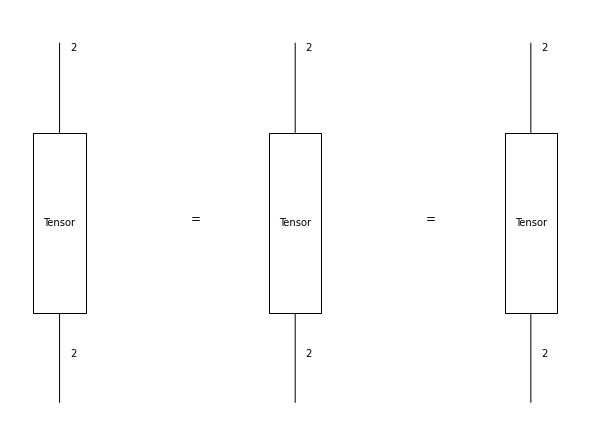

In [21]:
from discopy import drawing

drawing.equation(cap @ _id >> _id @ cup, _id, _id @ cap >> cup @ _id, figsize=(8, 6))

In order to draw a more meaningful equation, we need to draw diagrams, not boxes. We can use the special ```Cup``` and ```Cap``` boxes to draw bended wires.

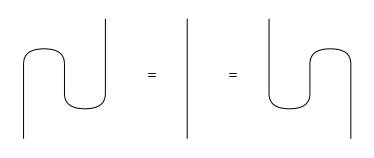

In [23]:
from discopy import Cup, Cap, Id

left_snake = Cap(Dim(2), Dim(2)) @ Id(Dim(2)) >> Id(Dim(2)) @ Cup(Dim(2), Dim(2))
right_snake = Id(Dim(2)) @ Cap(Dim(2), Dim(2)) >> Cup(Dim(2), Dim(2)) @ Id(Dim(2))

drawing.equation(left_snake, Id(Dim(2)), right_snake, figsize=(5, 2), draw_type_labels=False)

Two diagrams that are drawn differently cannot be equal Python objects: they have different lists of boxes and offsets. What we can say however, is that the diagrams are interpreted as the same ```Tensor``` box. This interpretation can be computed using a ```tensor.Functor```, defined by two mappings: ```ob``` from type to dimension (e.g. ```qubit``` to ```Dim(2)```) and ```ar``` from box to array (e.g. ```X``` to ```[0, 1, 1, 0]```). For now let’s take these two mappings to be identity functions.

In [24]:
from discopy import tensor
_eval = tensor.Functor(
    ob=lambda x: x,
    ar=lambda f: f)

assert _eval(left_snake) == _eval(Id(Dim(2))) == _eval(right_snake)

A ```tensor.Diagram```, also called a **tensor network**, is a subclass of ```Diagram``` equipped with such an ```eval``` method. A ```tensor.Box```, also called a **node** in a tensor network, is a subclass of ```Box``` equipped with an attribute ```array```. The evaluation a tensor diagram, i.e. the ```tensor.Functor``` that maps each box to its array, is also called **tensor contraction**.

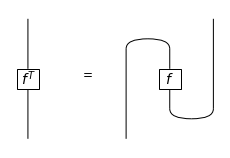

In [25]:
f = tensor.Box("$f$", Dim(2), Dim(2), [1, 2, 3, 4])
f_T = tensor.Box("$f^T$", Dim(2), Dim(2), [1, 3, 2, 4])

diagram = tensor.Diagram(
    dom=Dim(2), cod=Dim(2),
    boxes=[Cap(Dim(2), Dim(2)), f, Cup(Dim(2), Dim(2))],
    offsets=[0, 1, 1])

drawing.equation(f_T, diagram, figsize=(3, 2), fontsize=14, draw_type_labels=False)

assert not f_T == diagram
assert f_T.eval() == diagram.eval()

The distinction between a ```tensor.Diagram``` and its interpretation as a ```Tensor``` is crucial. Indeed, two diagrams that evaluate to the same tensor may take very different times to compute. For example:

In [26]:
%timeit diagram.eval()

5.21 ms ± 477 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%timeit f_T.eval()

189 µs ± 6.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Bibliography

[1] [Discopy](https://github.com/oxford-quantum-group/discopy)

[2] [QNLP tutorial](https://discopy.readthedocs.io/en/main/notebooks/qnlp-tutorial.html)